# Failure of losses relaxation

Illustration of when the $$P_{losses} \geq \text{convex expression}$$inequality is not tight. I.e. emergence of extraneous losses.

Pierre Haessig, November 2020

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Test-case-A:-Production-at-negative-price" data-toc-modified-id="Test-case-A:-Production-at-negative-price-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test case A: Production at negative price</a></span><ul class="toc-item"><li><span><a href="#Scenario" data-toc-modified-id="Scenario-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Scenario</a></span></li><li><span><a href="#Resolution-and-plot-routine" data-toc-modified-id="Resolution-and-plot-routine-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Resolution and plot routine</a></span></li><li><span><a href="#Solution-with-no-losses-(relaxed-or-not)" data-toc-modified-id="Solution-with-no-losses-(relaxed-or-not)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Solution with no losses (relaxed or not)</a></span></li><li><span><a href="#Solution-with-linear-in-E-losses-(relaxed-or-not)" data-toc-modified-id="Solution-with-linear-in-E-losses-(relaxed-or-not)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Solution with linear-in-E losses (relaxed or not)</a></span></li><li><span><a href="#Solution-with-quad-in-P-losses-(relaxed-only)" data-toc-modified-id="Solution-with-quad-in-P-losses-(relaxed-only)-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Solution with quad-in-P losses (relaxed only)</a></span></li></ul></li><li><span><a href="#Test-case-B-:-PV-production-with-soft-power-limit" data-toc-modified-id="Test-case-B-:-PV-production-with-soft-power-limit-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test case B : PV production with soft power limit</a></span><ul class="toc-item"><li><span><a href="#Optimization" data-toc-modified-id="Optimization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot</a></span></li><li><span><a href="#Interactive-plot-(unfinished-draft)" data-toc-modified-id="Interactive-plot-(unfinished-draft)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Interactive plot (unfinished draft)</a></span></li></ul></li></ul></div>

In [1]:
using Printf
using JuMP
# Solvers
using Ipopt
using ECOS
# Plot
using PyPlot

## Test case A: Production at negative price

System: grid injection (power $P_{grid}$), storage ($P_b$, with receptor convention) and prod ($P_{prod}$).

Power flow conservation:
$$ P_{grid} = P_{prod} - P_b $$

Storage dynamics:
$$E_b(k+1) = E_b(k+1) + (P_b(k)-P_{loss}(k))\Delta_t$$

Grid injection is _penalized_ (i.e. negative electricity price)

### Scenario

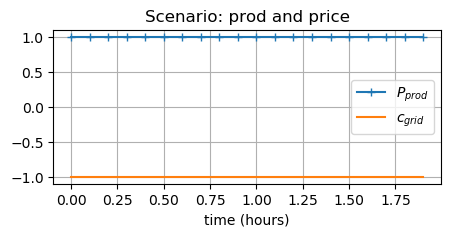

E_prod: 2.000 kWh

In [2]:
# Time vector: 2 hours, 0.1 h time step
n = 2*10
dt = 0.1
t = collect((0:n-1)*dt);

E_rated = 1.0 # kWh
P_prod = [ones(n÷2)
          ones(n÷2)]
c_grid = -1.0*ones(n) # €/kWh

figure(figsize=(5,2.))
plot(t, P_prod, "+-", label="\$P_{prod}\$")
plot(t, c_grid, label="\$c_{grid}\$")
xlabel("time (hours)")
title("Scenario: prod and price")
legend()
grid(true)

@printf("E_prod: %.3f kWh", sum(P_prod*dt))

### Resolution and plot routine

In [59]:
"""
    neg_price_prod(optimizer; relax=false, loss="zero", c_loss=0.1)

Create an optimization model for the negative price production problem.

- relax: whether the losses contraint is relaxed (>=) or not (==)
- loss: loss model ("zero", "linE", "quadP")
- c_loss: loss coefficient for linE and quadP models
"""
function neg_price_prod(optimizer; relax=false, loss="zero", c_loss=0.1)

    m = Model(optimizer)
    # silence solver output
    set_silent(m)

    # Variables:
    @variable(m, 0. <= Eb[1:n+1] <= E_rated) # storage energy
    @variable(m, Pb[1:n]) # storage power
    @variable(m, P_losses[1:n]) # storage losses
    @variable(m, 0. <= P_grid[1:n]) # injected grid power
    @variable(m, C_grid) # Total grid cost

    # Power flow
    @constraint(m, Pcons[k = 1:n],
                P_grid[k] == P_prod[k] - Pb[k])
    # Storage dynamics
    @constraint(m, Edyn[k = 1:n], 
                Eb[k+1] == Eb[k] + (Pb[k] - P_losses[k])*dt)
    # Initial energy: empty
    @constraint(m, Eb_ini, Eb[1] == 0.)
    # Total grid cost
    @constraint(m, C_grid == sum(P_grid .* c_grid)*dt)

    
    # Losses
    if loss == "zero"
        if relax
            @constraint(m, losses, P_losses .>= 0.0)
        else
            @constraint(m, losses, P_losses .== 0.0)
        end
    elseif loss == "linE"
        if relax
            @constraint(m, losses, P_losses .>= c_loss*Eb[1:end-1])
        else
            @constraint(m, losses, P_losses .== c_loss*Eb[1:end-1])
        end
    elseif loss == "quadP"
        if relax
            @constraint(m, losses, m[:P_losses] .>=  c_loss*Pb.^2)
        else
            error("Quad losses must be relaxed")
        end
    else
        error("Unknown loss model $loss")
    end    

    # Objective : Max grid benefit (negative) - penalties
    seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
    seq1_0 = 1 .- seq0_1
    discount = (1 .+ seq1_0) * 1e-5
    penal = sum(P_grid .* discount) + sum(P_losses .* discount)
    
    @objective(m, Max, C_grid - penal);
    optimize!(m)
    @printf("C_grid: %.3f €\n", value(C_grid))
    return m
end

neg_price_prod

In [50]:
figsize = (4,2.5)

(4, 2.5)

In [104]:
"""
    function prod_plot(m, title_str="")

Plot the trajectory of the production problem.
"""
function prod_plot(m, title_str="")
    P_grid = value.(m[:P_grid])
    Pb = value.(m[:Pb])
    Eb = value.(m[:Eb])
    P_losses = value.(m[:P_losses])
    
    figure(figsize = figsize)
    plot(t, P_grid, "x-", label="\$P_{grid}\$", ms=10)
    plot(t, Eb[1:end-1], "-", label="\$E_b\$")
    plot(t, Pb, "o-", label="\$P_b\$")
    plot(t, P_losses, "d-", label="\$P_{loss}\$", ms=5)

    title(title_str)
    ylim(-0.08, 1.08)
    legend()
    grid(true)
    tight_layout(pad=0.1)
end

prod_plot

### Solution with no losses (relaxed or not)

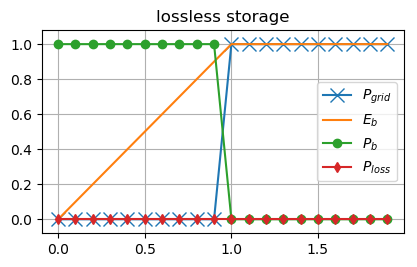

C_grid: -1.000 €


In [120]:
m = neg_price_prod(ECOS.Optimizer; relax=false, loss="zero")
prod_plot(m, "lossless storage")

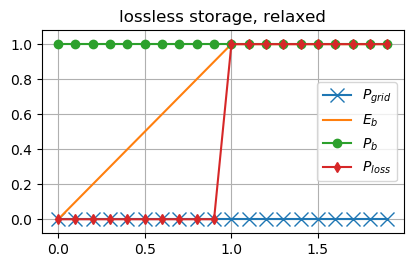

C_grid: -0.000 €


In [121]:
m = neg_price_prod(ECOS.Optimizer; relax=true, loss="zero")
prod_plot(m, "lossless storage, relaxed")

### Solution with linear-in-E losses (relaxed or not)

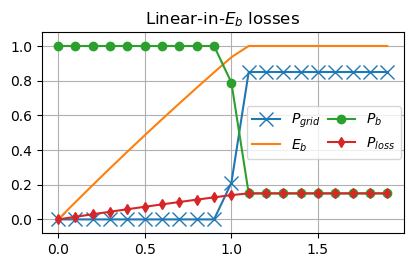

C_grid: -0.786 €


In [113]:
c_loss=0.15
m = neg_price_prod(ECOS.Optimizer; relax=false, loss="linE", c_loss=c_loss)
prod_plot(m, "Linear-in-\$E_b\$ losses")
legend(ncol=2, loc="center right", columnspacing=0.5, borderaxespad=0.2)

savefig("scenario plots/prod_neg_linE.pdf")
savefig("scenario plots/prod_neg_linE.png", dpi=300)

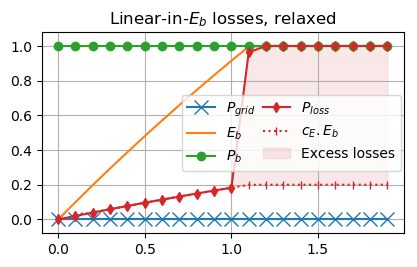

C_grid: -0.000 €


In [119]:
m = neg_price_prod(ECOS.Optimizer; relax=true, loss="linE", c_loss=c_loss)
prod_plot(m, "Linear-in-\$E_b\$ losses, relaxed")

# compute and show excess losses
Eb = value.(m[:Eb])
P_loss = value.(m[:P_losses])
P_loss_bound = c_loss*Eb[1:end-1]

plot(t, P_loss_bound, "C3:|", label="\$c_E.E_b\$")
fill_between(t, P_loss_bound, P_loss, alpha=0.1, color="C3", label="Excess losses")
legend(ncol=2, loc="center right", columnspacing=0.5, borderaxespad=0.2)

savefig("scenario plots/prod_neg_linE_relaxed.pdf")
savefig("scenario plots/prod_neg_linE_relaxed.png", dpi=300)

### Solution with quad-in-P losses (relaxed only)

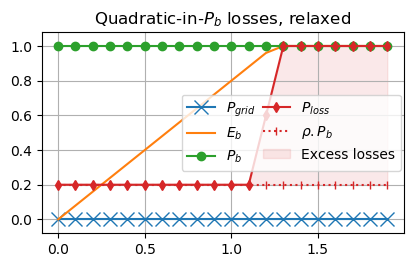

C_grid: -0.000 €


PyObject <matplotlib.legend.Legend object at 0x7f97f3fa2860>

In [118]:
c_loss = 0.2
m = neg_price_prod(ECOS.Optimizer; relax=true, loss="quadP", c_loss=c_loss)
prod_plot(m, "Quadratic-in-\$P_b\$ losses, relaxed")

# compute and show excess losses
Pb = value.(m[:Pb])
P_loss = value.(m[:P_losses])
P_loss_bound = c_loss*Pb.^2

plot(t, P_loss_bound, "C3:|", label="\$\\rho.P_b\$")
fill_between(t, P_loss_bound, P_loss, alpha=0.1, color="C3", label="Excess losses")
legend(ncol=2, loc="center right", columnspacing=0.5, borderaxespad=0.2)

---

## Test case B : PV production with soft power limit

(more complex example, too complex for the conference paper)

PV production, injected with a soft power limit (excess power is penalized)

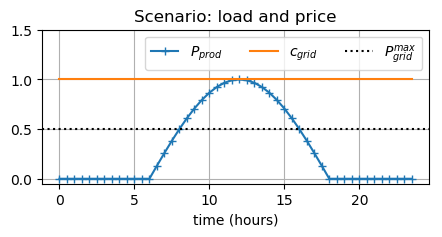

E_prod: 7.629 kWh

In [103]:
# Time vector: 24 hours, 0.5 h time step
n = 2*24
dt = 0.5
t = collect((0:n-1)*dt);

E_rated = 2.0 # kWh
P_grid_max = 0.5 # kW
P_prod = max.(-cos.(2*pi*t/24), 0.)
c_grid = ones(n)*1.0 # €/kWh

figure(figsize=(5,2.))
plot(t, P_prod, "+-", label="\$P_{prod}\$")
plot(t, c_grid, label="\$c_{grid}\$")
axhline(P_grid_max, ls=":", color="k", label="\$P_{grid}^{max}\$")
xlabel("time (hours)")
ylim(ymax=1.5)
title("Scenario: prod and price")
legend(ncol=3)
grid(true)

@printf("E_prod: %.3f kWh", sum(P_prod*dt))

### Optimization

In [104]:
ρ0 = 0.1 # kW/kW²

0.1

In [147]:
optimizer = ECOS.Optimizer

m = Model(optimizer)
# silence solver output
set_silent(m)

cex = 1.5

# Variables:
@variable(m, 0. <= Eb[1:n+1] <= E_rated) # storage energy
@variable(m, Pb[1:n]) # storage power
@variable(m, P_losses[1:n]) # storage losses
@variable(m, 0. <= P_grid[1:n]) # grid power
@variable(m, 0. <= P_gex[1:n]) # excess of grid power
@variable(m, C_grid) # Total grid cost
@variable(m, C_gex) # Total excess power cost


# Excess power should be max(P_grid - P_grid_max, 0)
@constraint(m, gex[k = 1:n],
            P_gex[k] >= P_grid[k] - P_grid_max)
# Power flow
@constraint(m, Pcons[k = 1:n],
            P_grid[k] == P_prod[k] - Pb[k])
# Storage dynamics
@constraint(m, Edyn[k = 1:n], 
            Eb[k+1] == Eb[k] + (Pb[k] - P_losses[k])*dt)
# Initial energy: empty
@constraint(m, Eb_ini, Eb[1] == 0.)
# Total grid cost
@constraint(m, C_grid == sum(P_grid .* c_grid)*dt)
@constraint(m, C_gex == cex * sum(P_gex .* c_grid)*dt)

# Losses
#@constraint(m, losses, m[:P_losses] .>= 0.001*ρ0 * m[:Pb].^2)
@constraint(m, losses, m[:P_losses] .== 0.001*m[:Eb][1:end-1])
#@constraint(m, losses, m[:P_losses] .>= 0.001*m[:Eb][1:end-1])
#@constraint(m, losses, m[:P_losses] .>= 0.0)
#@constraint(m, losses, m[:P_losses] .== 0.0)

seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = seq0_1 * 1e-5

@objective(m, Max, C_grid - C_gex + sum(m[:P_grid] .* discount) );

In [148]:
optimize!(m)
@printf("C_grid: %.3f\n", value(C_grid))
@printf("C_gex:  %.3f\n", value(C_gex))
@printf("Delta:  %.3f\n", value(C_grid) - value(C_gex))

C_grid: 7.613
C_gex:  0.897
Delta:  6.716


### Plot

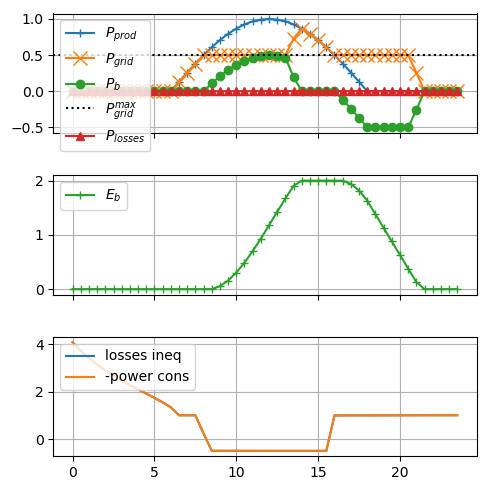

In [149]:
P_grid = value.(m[:P_grid])
Pb = value.(m[:Pb])
Eb = value.(m[:Eb])
P_losses = value.(m[:P_losses])


fig, ax = subplots(3,1, sharex=true, figsize=(5,5))
ax[1].plot(t, P_prod, "+-", label="\$P_{prod}\$")
ax[1].plot(t, P_grid, "x-", label="\$P_{grid}\$", ms=10)
ax[1].plot(t, Pb, "o-", label="\$P_b\$")
ax[1].axhline(P_grid_max, ls=":", color="k", label="\$P_{grid}^{max}\$")

ax[2].plot(t, Eb[1:end-1], "C2+-", label="\$E_b\$")
ax[1].plot(t, P_losses, "C3^-", label="\$P_{losses}\$")

ax[3].plot(t, dual.(m[:losses])/dt, label="losses ineq")
ax[3].plot(t, -dual.(m[:Pcons])/dt, label="-power cons")


for axi in ax
    axi.grid(true)
    axi.legend(loc="upper left")
end

tight_layout()

### Interactive plot (unfinished draft)

In [159]:
Interact.WebIO.install_jupyter_labextension() # might be helpful if you see `WebIO` warnings in Jupyter

┌ Info: Using default Jupyter executable at `/home/pierre/Programmes/miniconda3.7/bin/jupyter`; to use a different executable, see the documentation by running `?WebIO.install_jupyter_labextension`.
└ @ WebIO /home/pierre/.julia/packages/WebIO/Fy9h1/deps/jupyter.jl:198


An error occured.
ValueError: No linked package for @webio/webio
See the log file for details:  /tmp/jupyterlab-debug-b5781buj.log


Uninstalling @webio/jupyter-lab-provider from /home/pierre/Programmes/miniconda3.7/share/jupyter/lab/extensions


[LabBuildApp] JupyterLab 2.2.6
[LabBuildApp] Building in /home/pierre/Programmes/miniconda3.7/share/jupyter/lab
[LabBuildApp] Building jupyterlab assets (build:prod:minimize)


Process(`/home/pierre/Programmes/miniconda3.7/bin/jupyter lab build`, ProcessExited(0))

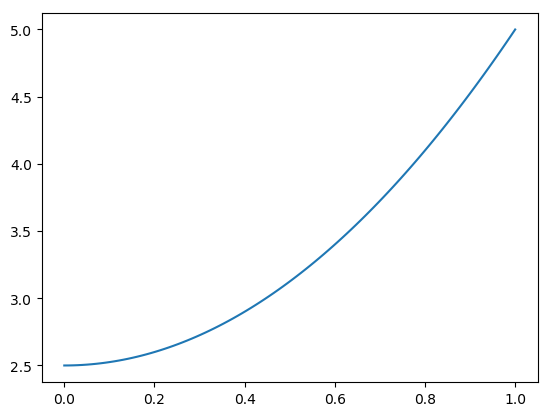

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["λ"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 51,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict(

In [160]:
using Interact
## 
@manipulate throttle=.05 for λ=0:.1:5, μ=0:.1:5
    xs = range(0.0, 1.0, length = 100)
    plot(xs, λ*xs.^2 .+ μ)
end